# Automatic Grader with Azure OpenAI ChatGPT
This notebook can grade students’ assignments automatically by downloading them from Moodle LMS. It will unzip the assignment file from Moodle and create a folder for each student. If a student submits a zip file, it will also unzip it in their folder. The folder should contain either some Docx files or one PDF file. For Docx files, the notebook will extract and merge all the texts into one answer. For PDF files, it will only extract the text from the first page as the answer.

The notebook will then use a marking scheme as prompts and let Azure OpenAI ChatGPT evaluate the answer according to the rules. It will also estimate the probability that the answer is copied from the internet or generated by AI.

The notebook will use Azure OpenAI text-embedding-ada-002 to get the embedding of the answer. It will then use K-means clustering to group the answers based on their embeddings and show the teachers the different types of answers. It will also perform PCA on the embeddings and plot the first three principal components in 3D. This will help the teachers see how similar or different the answers are.

### Install packages

In [1]:
%pip install -q pypandoc docx2txt PyPDF2 openpyxl python-dotenv openai num2words matplotlib plotly scipy scikit-learn pandas tiktoken ipywidgets seaborn ipympl PyQt6 pdfplumber
%load_ext dotenv
%dotenv

Note: you may need to restart the kernel to use updated packages.
cannot find .env file


You should consider upgrading via the 'c:\Users\callu\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


### Submit Files

In [1]:
import sys
import os
import shutil
from PyQt6.QtWidgets import (
    QApplication, QWidget, QVBoxLayout, QPushButton, QFileDialog, QLabel,
    QListWidget, QListWidgetItem, QMessageBox, QHBoxLayout
)
from PyQt6.QtCore import Qt, QDir
from PyQt6.QtGui import QDragEnterEvent, QDropEvent

class PDFUploader(QWidget):
    def __init__(self):
        super().__init__()

        self.setWindowTitle("Upload Student Assessments")
        self.setGeometry(100, 100, 600, 400)

        # Main layout
        layout = QVBoxLayout()

        # Title
        title_label = QLabel("<h2>Upload Student Assessments</h2>")
        layout.addWidget(title_label)

        # Instruction Label
        instruction_label = QLabel("Upload PDF files to receive automated feedback and analysis")
        layout.addWidget(instruction_label)

        # Drag-and-Drop Area
        self.drop_label = QLabel("Drag and drop your PDF files here\nor click 'Browse Files'")
        self.drop_label.setAlignment(Qt.AlignmentFlag.AlignCenter)
        self.drop_label.setStyleSheet("border: 2px dashed #ccc; padding: 20px;")
        layout.addWidget(self.drop_label)

        # Enable accepting drops
        self.setAcceptDrops(True)

        # Browse Button
        self.browse_button = QPushButton("Browse Files")
        self.browse_button.clicked.connect(self.browse_files)
        layout.addWidget(self.browse_button)

        # Selected Files List
        self.file_list = QListWidget()
        layout.addWidget(self.file_list)

        # Buttons Layout (Cancel & Upload)
        btn_layout = QHBoxLayout()
        self.cancel_button = QPushButton("Cancel")
        self.upload_button = QPushButton("Upload")
        self.upload_button.setStyleSheet("background-color: #4a69bd; color: white; padding: 5px;")
        
        self.cancel_button.clicked.connect(self.cancel_upload)
        self.upload_button.clicked.connect(self.upload_files)

        btn_layout.addWidget(self.cancel_button)
        btn_layout.addWidget(self.upload_button)
        layout.addLayout(btn_layout)

        self.setLayout(layout)
        self.selected_files = []

    def browse_files(self):
        files, _ = QFileDialog.getOpenFileNames(self, "Select PDF files", "", "PDF Files (*.pdf)")
        if files:
            for file in files:
                if file not in self.selected_files:
                    self.selected_files.append(file)
                    item = QListWidgetItem(os.path.basename(file))
                    remove_button = QPushButton("Remove")
                    remove_button.clicked.connect(lambda _, f=file: self.remove_file(f))
                    
                    widget = QWidget()
                    hbox = QHBoxLayout()
                    hbox.addWidget(QLabel(os.path.basename(file)))
                    hbox.addWidget(remove_button)
                    hbox.setContentsMargins(0, 0, 0, 0)
                    widget.setLayout(hbox)

                    list_item = QListWidgetItem()
                    self.file_list.addItem(list_item)
                    self.file_list.setItemWidget(list_item, widget)

    def remove_file(self, file):
        self.selected_files.remove(file)
        for i in range(self.file_list.count()):
            item_widget = self.file_list.itemWidget(self.file_list.item(i))
            if item_widget and isinstance(item_widget.layout().itemAt(0).widget(), QLabel):
                if item_widget.layout().itemAt(0).widget().text() == os.path.basename(file):
                    self.file_list.takeItem(i)
                    break

    def upload_files(self):
        target_folder = os.path.join(os.getcwd(), "Files")
        os.makedirs(target_folder, exist_ok=True)

        if not self.selected_files:
            QMessageBox.warning(self, "No Files", "Please select files before uploading.")
            return

        for file in self.selected_files:
            shutil.copy(file, target_folder)

        QMessageBox.information(self, "Upload Complete", f"Files uploaded successfully to {target_folder}")
        self.file_list.clear()
        self.selected_files = []

    def cancel_upload(self):
        self.close()

    def dragEnterEvent(self, event: QDragEnterEvent):
        if event.mimeData().hasUrls():
            event.acceptProposedAction()

    def dropEvent(self, event: QDropEvent):
        for url in event.mimeData().urls():
            dropped_path = url.toLocalFile()
            if os.path.isdir(dropped_path):  # If it's a directory
                self.add_files_from_folder(dropped_path)
            elif dropped_path.lower().endswith('.pdf'):  # If it's a PDF file
                self.add_pdf(dropped_path)

    def add_files_from_folder(self, folder_path):
        for root, _, files in os.walk(folder_path):
            for file in files:
                if file.lower().endswith('.pdf'):
                    self.add_pdf(os.path.join(root, file))

    def add_pdf(self, file_path):
        if file_path not in self.selected_files:
            self.selected_files.append(file_path)
            item = QListWidgetItem(os.path.basename(file_path))
            remove_button = QPushButton("Remove")
            remove_button.clicked.connect(lambda _, f=file_path: self.remove_file(f))
            
            widget = QWidget()
            hbox = QHBoxLayout()
            hbox.addWidget(QLabel(os.path.basename(file_path)))
            hbox.addWidget(remove_button)
            hbox.setContentsMargins(0, 0, 0, 0)
            widget.setLayout(hbox)

            list_item = QListWidgetItem()
            self.file_list.addItem(list_item)
            self.file_list.setItemWidget(list_item, widget)

if __name__ == "__main__":
    app = QApplication(sys.argv)
    window = PDFUploader()
    window.show()
    sys.exit(app.exec())


SystemExit: 0

C:\Users\callu\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Common Functions

In [2]:
def read_text_file(file_path):
    with open(file_path, "r", encoding="utf-8", errors="replace") as file:
        return file.read()


In [ ]:
import pdfplumber

def extract_text_pdfplumber(pdf_path):
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text() 

    return text

## Grading students’ responses using Azure OpenAI ChatGPT

In [ ]:
student_answer_pdf = extract_text_pdfplumber("Files\Copy of FYP UP2061187.pdf")

In [5]:
import os
import json
import openai
from openai import AzureOpenAI

api_key = os.getenv("AZURE_OPENAI_API_KEY")

marking_scheme = read_text_file("marking_scheme.txt")
student_answer = student_answer_pdf
prompt=marking_scheme.replace("<ANSWER></ANSWER>", student_answer)

client = AzureOpenAI(
    api_version="2023-07-01-preview",
    azure_endpoint="https://up206-m6upi167-swedencentral.cognitiveservices.azure.com/openai/deployments/gpt-35-turbo-16k/chat/completions?api-version=2024-08-01-preview",
    api_key=api_key 
)


completion = client.chat.completions.create(
    model="gpt-35-turbo-16k",  # e.g. gpt-35-instant
    messages=[
        {
            "role": "system", "content": "You are a teaching assistant.",
            "role": "user", "content": prompt,
        },
    ],
)
completion_dict = completion.model_dump()
response_content = completion_dict["choices"][0]["message"]["content"]
print(response_content)




{
  "Statement of project’s context, aims and objectives.": 75,
  "Critical review of relevant literature.": 70,
  "Methodological approach.": 0,
  "Specification and discussion of the requirements.": 0,
  "Analysis and discussion of the IT design.": 50,
  "Discussion of implementation.": 40,
  "Discussion of verification and validation.": 60,
  "Evaluation against requirements.": 0,
  "Evidence of project planning and management.": 0,
  "Attributes of the solution.": 0,
  "Summary, conclusions and recommendations.": 50,
  "Structure and presentation.": 60,
  "Overall understanding and reflection.": 40,
  "Final Mark": 30,
  "Comments": "Thank you for sharing your final-year project. Your statement of project's context, aims, and objectives is well-presented and demonstrates a clear understanding of the problem. Your literature review is thorough and provides a critical analysis of relevant sources. However, it is important to include a section on the methodological approach to show ho

## Cleaning Output

In [11]:
import pandas as pd
import json

# Convert string to dictionary
response_dict = json.loads(response_content)

# Convert to DataFrame with one row
df = pd.DataFrame([response_dict], index=["Student_1"])

# Transpose the table for better readability
df = df.transpose()

# Display the DataFrame
print(df)


                                                                                            Student_1
Statement of project’s context, aims and object...                                                 75
Critical review of relevant literature.                                                            70
Methodological approach.                                                                            0
Specification and discussion of the requirements.                                                   0
Analysis and discussion of the IT design.                                                          50
Discussion of implementation.                                                                      40
Discussion of verification and validation.                                                         60
Evaluation against requirements.                                                                    0
Evidence of project planning and management.                                      

## Anaylse Results: 

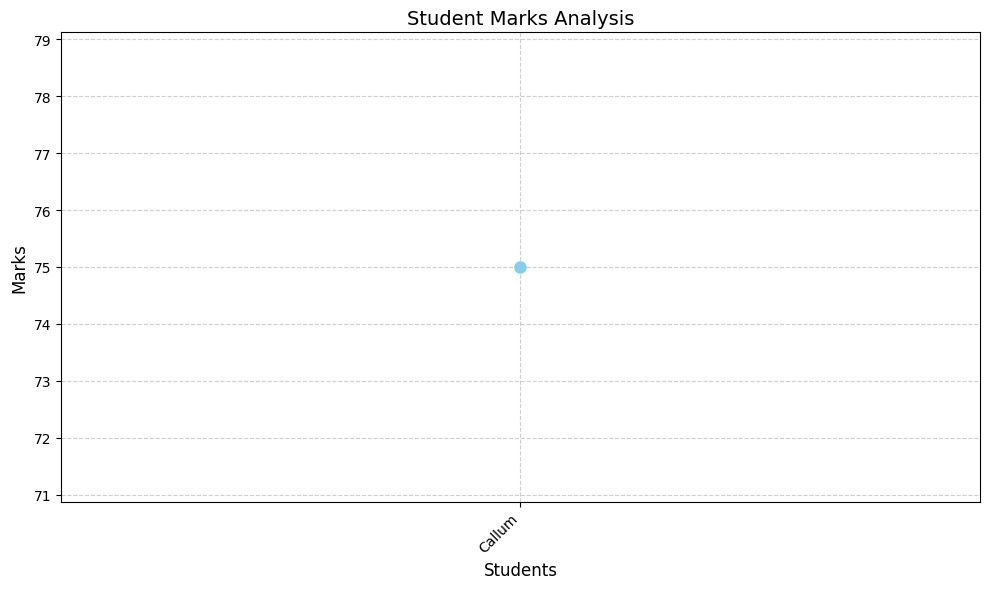

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample dataframe (replace this with your actual dataframe)
data = {
    "Student": ["Callum"],
    "marks": [75],
}
df_total = pd.DataFrame(data)

# Extract the required columns
students = df_total['Student']
marks = df_total['marks']

# Create a plot chart to analyze the results
plt.figure(figsize=(10, 6))
plt.plot(students, marks, marker='o', color='skyblue', linestyle='-', linewidth=2, markersize=8)

# Add labels and title
plt.xlabel("Students", fontsize=12)
plt.ylabel("Marks", fontsize=12)
plt.title("Student Marks Analysis", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()


In [2]:
import os
import json
import pandas as pd
import openai
from openai import AzureOpenAI

# Function to extract text from a PDF
def extract_text_pdfplumber(pdf_path):
    import pdfplumber
    with pdfplumber.open(pdf_path) as pdf:
        text = "\n".join([page.extract_text() for page in pdf.pages if page.extract_text()])
    return text

# Function to read the marking scheme
def read_text_file(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return f.read()

# Set up Azure OpenAI API
api_key = os.getenv("AZURE_OPENAI_API_KEY")

client = AzureOpenAI(
    api_version="2023-07-01-preview",
    azure_endpoint="https://up206-m6upi167-swedencentral.cognitiveservices.azure.com/openai/deployments/gpt-35-turbo-16k/chat/completions?api-version=2024-08-01-preview",
    api_key=api_key 
)

# Path to the folder containing student PDFs
files_dir = "Files"
marking_scheme = read_text_file("marking_scheme.txt")

# List to store results
results = []

# Loop through all PDF files in the folder
for file_name in os.listdir(files_dir):
    if file_name.endswith(".pdf"):  # Process only PDF files
        file_path = os.path.join(files_dir, file_name)
        student_answer = extract_text_pdfplumber(file_path)
        
        # Replace placeholder in marking scheme
        prompt = marking_scheme.replace("<ANSWER></ANSWER>", student_answer)
        
        # Send request to OpenAI API
        completion = client.chat.completions.create(
            model="gpt-35-turbo-16k",
            messages=[
                {"role": "system", "content": "You are a teaching assistant."},
                {"role": "user", "content": prompt},
            ],
        )


        # Extract response content
        completion_dict = completion.model_dump()
        response_content = completion_dict["choices"][0]["message"]["content"]

        print(response_content)

        
        # Convert response to dictionary and add student name
        #response_dict = json.loads(response_content)

        #response_dict["Student"] = file_name  # Use filename as student ID

        # Append to results
        #results.append(response_dict)

# Convert list of dicts to DataFrame
#df = pd.DataFrame(results)

# Rearrange columns: Move "Student" to the first column
#df = df.set_index("Student")

# Display the DataFrame
#print(df)

{
  "Statement of project’s context, aims and objectives.": 75,
  "Critical review of relevant literature.": 70,
  "Methodological approach.": 0,
  "Specification and discussion of the requirements.": 0,
  "Analysis and discussion of the IT design.": 50,
  "Discussion of implementation.": 40,
  "Discussion of verification and validation.": 60,
  "Evaluation against requirements.": 0,
  "Evidence of project planning and management.": 0,
  "Attributes of the solution.": 0,
  "Summary, conclusions and recommendations.": 50,
  "Structure and presentation.": 60,
  "Overall understanding and reflection.": 40,
  "Final Mark": 30,
  "Comments": "Thank you for sharing your assignment. You have done a good job in presenting the context, aims, and objectives of your project. Your critical review of relevant literature demonstrates your ability to analyze existing work in the field. However, there are some areas that could be improved. The methodological approach, specification and discussion of r

In [7]:
files_dir = "Files"
marking_scheme = read_text_file("marking_scheme.txt")

# List to store results
results = []

# Loop through all PDF files in the folder
for file_name in os.listdir(files_dir):
    if file_name.endswith(".pdf"):  # Process only PDF files
        file_path = os.path.join(files_dir, file_name)
        student_answer = extract_text_pdfplumber(file_path)
        print(file_name)

Copy of FYP UP2061187 2.pdf
Copy of FYP UP2061187.pdf
